## Graph

1. We know from repeated tests that prices fit onto a logistical curve.


We first need a plot where the long term trend is correctly subtracted. \
We assume the long term trend is like a barchistocrone, a set of particles falling on a path towards a destined price. \
We must double test to see if that is correct.

In [40]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from scipy.interpolate import make_smoothing_spline
from scipy.signal import medfilt
from scipy.interpolate import UnivariateSpline

In [79]:
dal_df = yf.download("BTC-USD", start="2000-01-01", end="2025-01-01")
dal_1m_df = yf.download("BTC-USD", interval="1m", period="7d")

dal_df.columns = dal_df.columns.droplevel(1)
dal_df = dal_df.reset_index(drop = True)
dal_df["log_p"] = np.log(dal_df["Close"])

y = dal_df["Close"]
y_med = medfilt(y, kernel_size=9)   # 5, 9, 11...
t = dal_df.index

spl = UnivariateSpline(t, y_med, s=len(t)*np.var(y_med)*0.01)
t_new = np.linspace(t[0], t[-1], len(dal_df["Close"]))
y_smooth = spl(t_new)
dal_df["smooth_close"] = y_smooth

dal_df = dal_df.reset_index(drop = True)

C:\Users\Mark Brezina\AppData\Local\Temp\ipykernel_11444\2056831615.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dal_df = yf.download("BTC-USD", start="2000-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Mark Brezina\AppData\Local\Temp\ipykernel_11444\2056831615.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dal_1m_df = yf.download("BTC-USD", interval="1m", period="7d")
[*********************100%***********************]  1 of 1 completed


In [68]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# ---------- Candidate models ----------
def linear(t, a, b):
    return a + b*t

def expo(t, a, b):
    # unbounded exponential
    return a * np.exp(b*t)

def log_curve(t, a, b, c):
    # logarithmic growth (needs t > -c)
    return a + b*np.log(t + c)

def sat_exp(t, L, k, t0):
    # saturating exponential toward ceiling L
    # starts near 0 when t << t0 if you set t0 accordingly
    return L * (1 - np.exp(-k*(t - t0)))

def logistic(t, L, k, t_mid):
    # logistic with ceiling L and midpoint t_mid
    return L / (1 + np.exp(-k*(t - t_mid)))

# ---------- AIC / BIC ----------
def aic_bic(y, yhat, k_params):
    n = len(y)
    rss = np.sum((y - yhat)**2)
    # Gaussian errors -> log-likelihood up to a constant
    aic = n*np.log(rss/n) + 2*k_params
    bic = n*np.log(rss/n) + k_params*np.log(n)
    return aic, bic, rss

def fit_one(model_name, f, t, y, p0, bounds=(-np.inf, np.inf)):
    try:
        popt, pcov = curve_fit(f, t, y, p0=p0, bounds=bounds, maxfev=20000)
        yhat = f(t, *popt)
        aic, bic, rss = aic_bic(y, yhat, len(popt))
        return {
            "model": model_name,
            "params": popt,
            "AIC": aic,
            "BIC": bic,
            "RSS": rss
        }
    except Exception as e:
        return {
            "model": model_name,
            "params": None,
            "AIC": np.inf,
            "BIC": np.inf,
            "RSS": np.inf,
            "error": str(e)
        }

def compare_models(t, y):
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)

    # sensible initial guesses
    y_min, y_max = np.min(y), np.max(y)
    L0 = y_max  # ceiling guess
    k0 = 1.0 / max(1.0, (t[-1] - t[0]))
    tmid0 = t[np.argmax(np.gradient(y))] if len(y) > 3 else np.median(t)

    results = []
    results.append(fit_one("linear", linear, t, y, p0=[y_min, (y_max-y_min)/(t[-1]-t[0]+1e-9)]))
    results.append(fit_one("exponential", expo, t, y, p0=[max(y_min, 1e-6), 0.01]))
    results.append(fit_one("logarithmic", log_curve, t, y, p0=[y_min, 1.0, 1.0],
                           bounds=([-np.inf, -np.inf, 1e-9], [np.inf, np.inf, np.inf])))

    # for ceiling-type models, force L > 0 and k > 0
    results.append(fit_one("saturating_exp", sat_exp, t, y,
                           p0=[max(L0, 1e-6), max(k0, 1e-6), t[0]],
                           bounds=([1e-9, 1e-9, -np.inf], [np.inf, np.inf, np.inf])))

    results.append(fit_one("logistic", logistic, t, y,
                           p0=[max(L0, 1e-6), max(k0, 1e-6), tmid0],
                           bounds=([1e-9, 1e-9, -np.inf], [np.inf, np.inf, np.inf])))

    df = pd.DataFrame([{
        "model": r["model"],
        "AIC": r["AIC"],
        "BIC": r["BIC"],
        "RSS": r["RSS"],
        "params": r["params"]
    } for r in results]).sort_values("BIC")

    return df, results

# ---------- Usage ----------
# Suppose you have a DataFrame df with columns: 't' and 'y'
t = dal_df.index.values
y = dal_df.smooth_close.values

df_models, raw = compare_models(t, y)
print(df_models)


            model           AIC           BIC           RSS  \
1     exponential  69441.428514  69453.892330  3.958188e+11   
4        logistic  69443.436632  69462.132356  3.958196e+11   
0          linear  70432.705762  70445.169579  5.152562e+11   
3  saturating_exp  70434.730999  70453.426723  5.152596e+11   
2     logarithmic  70435.442048  70454.137773  5.153571e+11   

                                              params  
1         [2249.193975242793, 0.0009204958115627919]  
4  [1205379698.250496, 0.0009205169691474436, 143...  
0          [-11581.482061907043, 16.582536986585755]  
3  [1756199001.3520496, 9.442254976582017e-09, 69...  
2  [-909383591.6177555, 60205562.10609645, 362894...  


In [73]:
df_models.iloc[1,4]

array([1.20537970e+09, 9.20516969e-04, 1.43308246e+04])

In [71]:
import numpy as np
from scipy.stats import linregress

t = np.asarray(t, float)
y = np.asarray(y, float)

# avoid zeros/negatives
mask = y > 0
t, y = t[mask], y[mask]

dt = np.diff(t)
dy = np.diff(y)

# discrete per-capita growth rate
g = (dy/dt) / y[:-1]          # ~ (1/y) dy/dt
y_mid = y[:-1]

# exponential test: g ~ constant  (no trend vs time)
exp_test = linregress(t[:-1], g)

# logistic test: g ~ a + b*y with b < 0
logi_test = linregress(y_mid, g)

print("g vs time slope (should be ~0 for exponential):", exp_test.slope, "p:", exp_test.pvalue)
print("g vs y slope (should be <0 for logistic):", logi_test.slope, "p:", logi_test.pvalue)


g vs time slope (should be ~0 for exponential): -2.5278730388452854e-07 p: 0.5599024252766025
g vs y slope (should be <0 for logistic): -1.561661738223618e-08 p: 0.45577384746709426


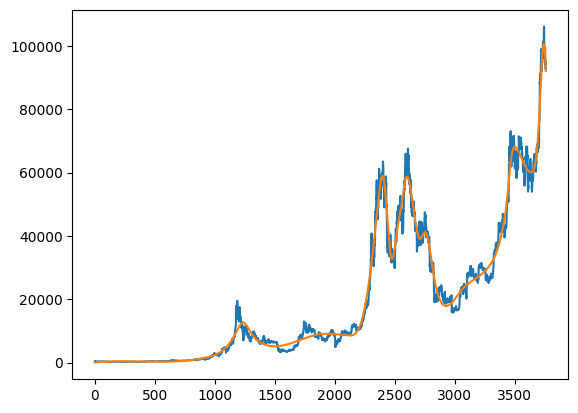

In [83]:
plt.plot(dal_df["Close"])
plt.plot(dal_df["smooth_close"])
#plt.plot((dal_df["smooth_close"] - dal_df["Close"])/dal_df["Close"])
#plt.xlim(5000,5100)
#plt.ylim(100,200)
plt.show()

## Market dynamics
We know there are (stochastic) volatility clusters, but in that respect there must be more to add to the risk side. \
We know there are trends, but that returns are "mostly" mean reverting even so. \
We know prices are mean-reverting around "plateaus" and that this can be described in some way with the lagrangian -taxonomic clusterings? \
We know that order imbalance plays a somewhat big role in pricing and an even bigger part in short-term pricing \

drift/trend) + feedback(self-reinforcement) + friction(liquidity) + shock + constraint(bound limits)


A + B(t_c - t)**2 * [1+C cos(w ln(t_c - t) + y)] 

persistence drag
shock dissipation - dissipation/stabilization
crowding/saturation - feedback loops
trend intensity decay - trend-reinforcing pressure
factor-sector coupling
return accumulatuin nodes - return driven drift
structural break zones
taxonomic clusterings?
regime dynamics regime evolution flow - baseline regime flow - cyclical regime forcing
mean reversion tension - pressure
nonlinear amplification
spatial smoothing
net directional drift / risk scaled normalization
baseline carry
phase rotation
return driven rotation
momemtum latitude bias
volatility banding
state hotspot
rotational turbulence
vol phase shift, time rotation
momentum tilt

drift term = systematic carry from being long/short volatility risk premia

price = (friction / sqrt(t) * implied volatility) * K(integral over measurable set of f_t(x,y) * wave-probability_t(x,y) divided by the f_t(x,y) lim at inf.